----------

# **<center>Sentiment Analysis** </center>
----------

**<br>2023F-T3 AML 2304 - Natural Language Processing**
<br>Group 1:
<br>&emsp;&emsp;Jefford Secondes - C0865112
<br>&emsp;&emsp;Jovi Fez Bartolata - C0869701
<br>&emsp;&emsp;Keyvan Amini - C0866360
<br>&emsp;&emsp;Lakpa Sherpa - C0874811
<br>&emsp;&emsp;Maricris Resma - C0872252
<br>&emsp;&emsp;Luz Zapanta - C0879190
<br>&emsp;&emsp;Lucia Martinez Torres - C0863954
<br>&emsp;&emsp;Pradeep Kumar Bhatt - C0875486


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import nltk
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import bz2
from langdetect import detect
from autocorrect import Speller
import spacy
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
import gensim.downloader as api
import plotly.express as px
import pickle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Get data
df = pd.read_csv(r"reviews_250k.csv", header=None)

# Rename columns
df = df.rename(columns={0: 'rating', 1: 'title', 2: 'review'})

df.head()

In [ ]:
# Function to map language codes to labels
def map_language_label(language_code):
    language_mapping = {
        'en': 'English',
        'es': 'Espanol',
        'fr': 'French',
        'it': 'Italian',
        'af': 'Afrikaans',
        'pt': 'Portuguese',
        'de': 'German',
        'nl': 'Dutch',
        'cy': 'Welsh',
        'hr': 'Croatian',
        'so': 'Somali',
        'id': 'Indonesian',
        'sq': 'Albanian',
        'da': 'Danish',
        'fi': 'Finnish',
        'hu': 'Hungarian',
        # Add more language codes and labels as needed
    }
    return language_mapping.get(language_code, 'Other')

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

# Apply language detection to the data
df['language'] = df['review'].apply(detect_language)

# Map language codes to labels
df['language_label'] = df['language'].apply(map_language_label)

# Count the frequency of each language
language_counts = df['language_label'].value_counts()

# Visualize language frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=language_counts.index, y=language_counts.values)
plt.title('Language Frequency')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<b>Observation</b>: Majority of reviews are in English, but some are written in other languages.

In [ ]:
# Distribution of records by Rating
print('\nCount:')
print(df['rating'].value_counts())

print('\nDistribution:')
print(df['rating'].value_counts() / df.shape[0])

<b>Observation:</b> The data is almost equally distributed across all ratings. 

In [ ]:
# Function to map language codes to labels
def map_label(rating):
    if rating == 1 or rating == 2:
        return 0
    if rating == 3:
        return 1
    if rating == 4 or rating == 5:
        return 2

# Change all labels to 1 (positive) and 0 (negative)
df['label'] = df['rating'].apply(map_label)

# Retain records with english reviews
df = df[df['language'] == 'en'] 

# Distribution of records by rating and label
df.pivot_table(index='rating', columns='label', aggfunc={'label':len}, fill_value=0)

In [ ]:
# Distribution by label
labels = ['Negative', 'Neutral', 'Positive']
sizes = [df[df['label'] == 0].shape[0], df[df['label'] == 1].shape[0], df[df['label'] == 2].shape[0]]
colors = ['#66b3ff', '#99ff99', '#ffcccb']

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sentiments in the Input Data')
plt.show()

## Data Preprocessing

In [ ]:
# Step 1: Perform Basic Regex

# Function to preprocess text
def preprocess_text_1(data):                                      
    text=str(data)                                              # Convert all text to strings
    text=re.sub(r'(http|https)?://\S+|www\.\S+','',text)        # Remove any links
    text = re.sub(r'[\d]+','',text)                             # Remove digits
    text=re.sub(r'\s{2,}',' ',text)                             # Remove multiple spaces
    return text

# Basic Regex
df['clean_text_1'] = df['review'].apply(preprocess_text_1)  # Preprocess text
df.head()

In [ ]:
# Step 2: Remove Named Entities

# Load spacy model
nlp = spacy.load("en_core_web_md")

# Function to remove named entities
def remove_named_entities(text):      
        
    document = nlp(text)
    no_named_entities = []

    for item in document:
        # If named entity, pass
        if item.text in [e.text for e in document.ents]:
            pass
        # Append non named entities
        else:
            no_named_entities.append(item.text)
            
    # Return no_named_entities
    return " ".join(no_named_entities)
    
df['clean_text_2'] = df['clean_text_1'].apply(lambda x: remove_named_entities(x))
df[['clean_text_1','clean_text_2']]

In [ ]:
# Skip for now. Stopped because it took more than 583 mins to run.

'''

# Step 3: Spell Corrector

spell = Speller(lang='en')

# Correct spelling
df['clean_text_3'] = df['clean_text_2'].apply(lambda x: spell(x))
df[['clean_text_2','clean_text_3']]

'''

In [ ]:
# Step 4: Perform More Regex

# Function to preprocess text
def preprocess_text_2(data):
    text=str(data)                                              # Convert all text to strings
    text=re.sub(r'[^a-zA-Z0-9\s]','',text)                      # Remove special characters
    text=text.lower()                                           # Convert to lowercase characters
    text=re.sub(r'[^\w\s]','',text)                             # Remove punctuation
    # Remove single characters
    #text=re.sub(r'\b\w\b','',text)                              
    return text

# Basic Regex - after running spell corrector
# df['clean_text_4'] = df['clean_text_3'].apply(preprocess_text_2)
# df[['clean_text_3','clean_text_4']]

# Basic Regex - without running spell corrector
df['clean_text_4'] = df['clean_text_2'].apply(preprocess_text_2)
df[['clean_text_2','clean_text_4']]

In [ ]:
# Skip for now. Stopped because it took more than 94 mins to run.

'''

# Step 5: POS Tagging
# Step 6: Stop Words
# Step 7: Lemmatizing or Stemming

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
pos_list = ['PRP',  # PRP personal pronoun I, he, she 
            'PRP$', # PRP$ possessive pronoun my, his, hers 
            'WP',   # WP wh-pronoun who, what 
            'WP$',  # WP$ possessive wh-pronoun, eg- whose
            'IN'    # IN preposition/subordinating conjunction 
            ]

# Function to remove pronouns, prepositions, and stop words
def remove_pos(text):
    
    word_list = word_tokenize(text)
    no_pos_stop = []
    
    for word in word_list:
        
        pos_tag = nltk.pos_tag([word])
        
        # If pronoun or preposition or stop word, drop
        if word in stop_words or pos_tag[0][1] in pos_list:
            pass
        
        # Else, append lemmatized word
        else:
            no_pos_stop.append(lemmatizer.lemmatize(word))
    
    return " ".join(no_pos_stop)
            
# Remove pronouns and prepositions
df['clean_text_5'] = df['clean_text_4'].apply(remove_pos)
df[['clean_text_4','clean_text_5']]

'''

In [ ]:
# Step 5: POS Tagging

pos_list = ['PRP',  # PRP personal pronoun –  I, he, she 
            'PRP$', # PRP$ possessive pronoun – my, his, hers 
            'WP',   # WP wh-pronoun – who, what 
            'WP$',  # WP$ possessive wh-pronoun, eg- whose
            'IN'    # IN preposition/subordinating conjunction 
            ]

# Function to remove pronouns, prepositions, and stop words
def remove_pos(text):
    
    word_list = word_tokenize(text)
    no_pos = []
    
    for word in word_list:
        
        pos_tag = nltk.pos_tag([word])
        
        # If pronoun or preposition, drop
        if pos_tag[0][1] in pos_list:
            pass
        
        # Else, append lemmatized word
        else:
            no_pos.append(word)
    
    return " ".join(no_pos)
            
# Remove pronouns and prepositions
df['clean_text_5'] = df['clean_text_4'].apply(remove_pos)
df[['clean_text_4','clean_text_5']]

In [ ]:
# Skip for now. Stopped because it took more than 106 mins to run.

'''

# Step 6: Stop Words
# Step 7: Lemmatizing or Stemming

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to remove pronouns, prepositions, and stop words
def remove_stop_words(text):
    
    word_list = word_tokenize(text)
    no_stop_words = []
    
    for word in word_list:
        
        # If stop word, drop
        if word in stop_words:
            pass
        
        # Else, append lemmatized word
        else:
            no_stop_words.append(lemmatizer.lemmatize(word))
    
    return " ".join(no_stop_words)
            
# Remove pronouns and prepositions - after running pos tag
# df['clean_text_6'] = df['clean_text_5'].apply(remove_stop_words)
# df[['clean_text_5','clean_text_6']]

# Remove pronouns and prepositions - without running pos tag
df['clean_text_6'] = df['clean_text_4'].apply(remove_stop_words)
df[['clean_text_4','clean_text_6']]

'''

In [ ]:
# Step 6: Stop Words
# Step 7: Lemmatizing or Stemming

# Function to remove pronouns, prepositions, and stop words
def remove_stop_words(text):
    
    text = nlp(text)
    no_stop_words = []
    
    for token in text:
        
        # If stop word, drop
        if token.is_stop:
            continue
        
        # Else, append lemmatized word
        no_stop_words.append(token.lemma_)

    return no_stop_words

# Remove stop words and lemmatize - after running pos tag
# df['clean_text_6'] = df['clean_text_5'].apply(remove_stop_words)
# df[['clean_text_5','clean_text_6']]

# Remove stop words and lemmatize - without running pos tag
df['clean_text_6'] = df['clean_text_4'].apply(remove_stop_words)
df[['clean_text_4','clean_text_6']]

In [ ]:
# Create data for modeling

# Keep relevant fields only
df_model = df[['label', ,'clean_text_4','clean_text_6','rating']]

# Rename columns
df_model = df_model.rename(columns={'clean_text_6':'word_tokens', 'clean_text_4':'clean_doc'})

# Tokenize text
# df_model['word_tokens'] = df_model['clean_text'].apply(lambda x: word_tokenize(x))

# Word count
df_model['number_of_words'] = df_model['word_tokens'].apply(lambda x: len(x))

df_model.head()

In [ ]:
# Export data so that other members don't need to run the entire script
df.to_csv('preprocessed_data.csv', index=False)
df_model.to_csv('model_data.csv', index=False)

    - Note: pre-processed data

In [2]:
# Get processed data
df = pd.read_csv('preprocessed_data.csv', header=0)
df_model = pd.read_csv('model_data.csv', header=0)

## Exploratory Data Analysis

In [3]:
# Print the results
print("Null values in the model data:")
print(df_model.isnull().sum())

Null values in the model data:
label              0
word_tokens        0
rating             0
number_of_words    0
dtype: int64


<b>Observation:</b> No null/missing data.

Average word count per review: 31.98


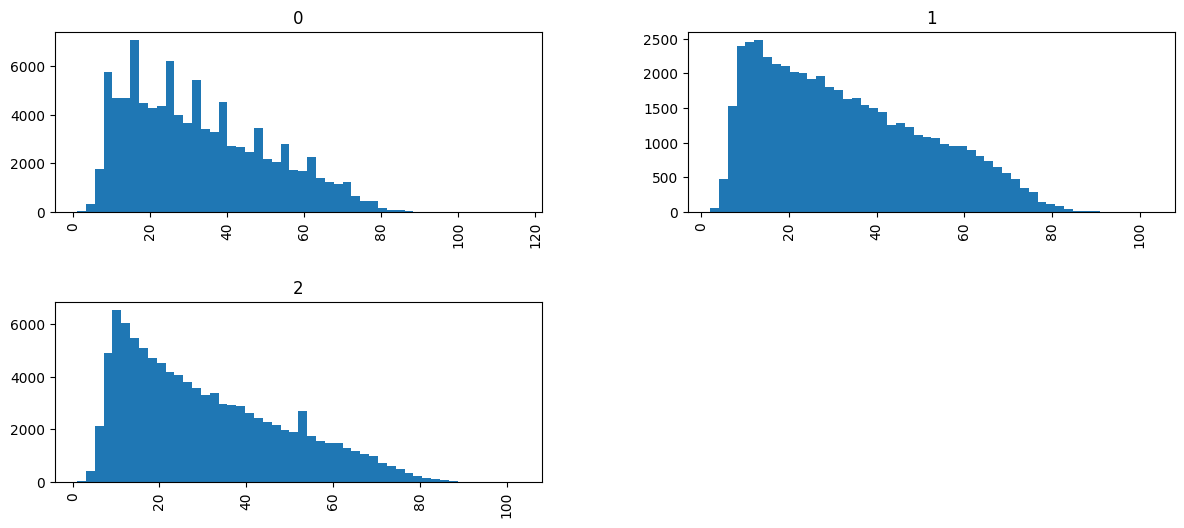

In [4]:
# Plot word count
df_model.hist(column='number_of_words', by='label', bins=50,figsize=(14,6))

# Calculate the average word count per review
average_word_count = df_model['number_of_words'].mean()
print(f"Average word count per review: {average_word_count:.2f}")

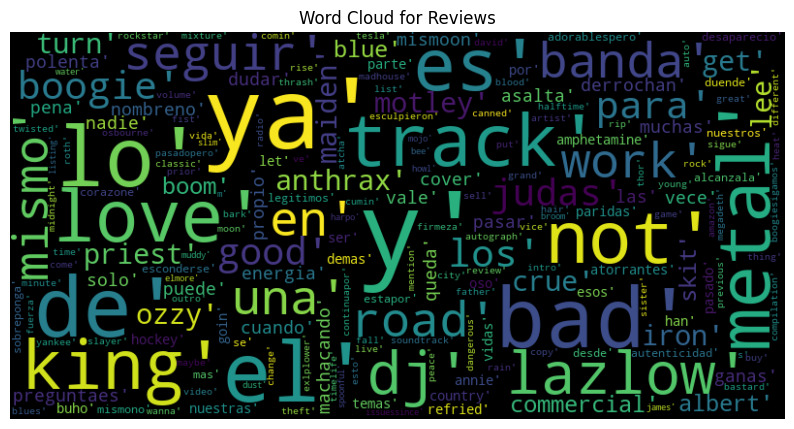

In [5]:
# Visualize the common words using a word cloud
high_word_count_reviews = df_model[df_model['number_of_words'] > 100]  # Adjust the threshold as needed

wordcloud_text = ' '.join(high_word_count_reviews['word_tokens'])
# wordcloud_text = [' '.join(map(str, word)) for word in high_word_count_reviews['word_tokens']]
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(wordcloud_text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Reviews')
plt.show()

In [6]:
# Combine all reviews into a single list
# all_text = ' '.join(df_model['clean_text'])

# Tokenize words
# all_text_words = re.findall(r'\b\w+\b', all_text)

# Combine all reviews into a single list
# all_text_words = [' '.join(map(str, word)) for word in df_model['word_tokens']]
all_text_words = df_model['word_tokens'].values.tolist()
# all_text_words = [' '.join(map(str, word)) for word in df_model['word_tokens']]

# Count the frequency of each word
# all_text_word_count = Counter(all_text_words)

# Get the top N most common words
# top_words = all_text_word_count.most_common(20)  # Change 20 to the desired number of top words

# Convert the result into a DataFrame for easy plotting
# top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])

# Plot the bar chart
# plt.figure(figsize=(12, 6))
# sns.barplot(x='Word', y='Count', data=top_words_df, palette='viridis')
# plt.title('Top 20 Most Commonly Used Words')
# plt.xlabel('Word')
# plt.ylabel('Count')
# plt.xticks(rotation=45, ha='right')
# plt.show()

all_text_words

["['model', 'ok', 'sedentary', 'type', 'm', 'active', 'alot', 'job', 'consistently', 'find', 'stocking', 'roll', 'ankle', 'good', 'solution', 'standard', 'compression', 'stocking', 'stock', 'excellent', 'support', 'stay', 'give', 'need', 'pair', 'tear', 'struggle', 'pull', 'time', 'good', 'riddancebad', 'investment']",
 "['fast', 'read', 'fill', 'unexpected', 'humour', 'profound', 'insight', 'art', 'politic', 'policy', 'brief', 'sly', 'wry', 'wise']",
 "['buy', 'chargersthe', 'instruction', 'light', 'stay', 'battery', 'chargestrue', 'instruction', 'nt', 'light', 'turn', 'true', 'charge', 'light', 'stay', 'return', 'think', 'bad', 'unitthe', 'new', 'thing', 'keep', 'chargebut', 'light', 'useless', 'stay', 'backup', 'charger', 'manage', 'drain', 'aas', 'not', 'want', 'charger']",
 "['excited', 'find', 'book', 'ostensibly', 'feminism', 'volume', 'live', 'expectationsone', 'essay', 'thing', 'describe', 'veil', 'potentially', 'liberate', 'not', 'begin', 'explain', 'whyanother', 'woman', 'ca

## Train and Test Sets

In [7]:
# Split data into train and test sets
df_train, df_test = train_test_split(df_model, test_size=0.2, random_state=42)

print("Train set size:",df_train.shape)
print("Test set size:",df_test.shape)

Train set size: (199512, 4)
Test set size: (49878, 4)


## Word Embedding Using Word2Vec

In [8]:
# Load Word2Vec model
wv = api.load('word2vec-google-news-300')

# Function to get the mean of vectors - train
df_train_w2v = df_train[['label','word_tokens']]
df_train_w2v['w2v_vector'] = df_train_w2v['word_tokens'].apply(lambda x: wv.get_mean_vector(x))

print('\nword2vec train set shape:',df_train_w2v.shape)
print()
print(df_train_w2v.head())

y_train_w2v = df_train_w2v['label']
x_train_w2v = df_train_w2v['w2v_vector']

x_train_w2v_2 = np.stack(x_train_w2v)

print('\nx train shape:',x_train_w2v_2.shape)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


MemoryError: Unable to allocate 3.35 GiB for an array with shape (3000000, 300) and data type float32

In [9]:
# Function to get the mean of vectors - test
df_test_w2v = df_test[['label','word_tokens']]
df_test_w2v['w2v_vector'] = df_test_w2v['word_tokens'].apply(lambda x: wv.get_mean_vector(x))

print('\nword2vec test set shape:',df_test_w2v.shape)
print()
print(df_test_w2v.head())

y_test_w2v = df_test_w2v['label']
x_test_w2v = df_test_w2v['w2v_vector']

x_test_w2v_2 = np.stack(x_test_w2v)

print('\nx test shape:',x_test_w2v_2.shape)

MemoryError: Unable to allocate 3.35 GiB for an array with shape (3000000, 300) and data type float32

In [ ]:
# Standardize mean vectors
w2v_scaler = MinMaxScaler()
x_train_w2v_scaled = w2v_scaler.fit_transform(x_train_w2v_2)
x_test_w2v_scaled = w2v_scaler.transform(x_test_w2v_2)

In [ ]:
# Use PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=1234)
pca_w2v = pca.fit_transform(x_train_w2v_scaled)

# Plot class separabality
colors = {0:'negative', 1:'neutral', 2:'positive'}
fig = px.scatter(x=pca_w2v[:, 0], y=pca_w2v[:, 1], color=y_train_w2v.map(colors))
fig.show()

In [ ]:
# Export word2vec files
# df_train_w2v.to_csv('word2vec_train_set.csv', index=False)
# df_test_w2v.to_csv('word2vec_test_set.csv', index=False)
pickle.dump(w2v_scaler,open("w2v_scaler.pkl",'wb'))

In [ ]:
# Get word2vec files
# df_train_w2v = pd.read_csv('word2vec_train_set.csv', header=0)
# df_test_w2v = pd.read_csv('word2vec_test_set.csv', header=0)
# w2v_scaler = pickle.load(open("w2v_scaler.pkl",'rb'))

## Word Embedding Using TF-IDF
<!-- https://medium.com/@GeoffreyGordonAshbrook/vector-visualization-2d-plot-your-tf-idf-with-pca-83fa9fccb1d -->

In [4]:
# for initial TF-IDF use preprocessed_data 

df_model = df

NameError: name 'pd' is not defined

In [ ]:
# Split data into train and test sets
df_train, df_test = train_test_split(df_model, test_size=0.2, random_state=42)

print("Train set size:",df_train.shape)
print("Test set size:",df_test.shape)

Train set size: (199512, 10)
Test set size: (49878, 10)


## Vectorize text using TfidfVectorizer
Equivalent to CountVectorizer followed by TfidfTransformer.
<!-- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html -->
<!-- https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe -->
<!-- https://www.kdnuggets.com/2022/09/convert-text-documents-tfidf-matrix-tfidfvectorizer.html -->
<!-- https://hackernoon.com/document-term-matrix-in-nlp-count-and-tf-idf-scores-explained -->
<!-- https://stackoverflow.com/questions/32591629/scikit-learn-calculating-tf-idf-from-a-corpus-of-arrays-of-features-instead-of -->

In [ ]:
df_train.head(2)

,rating,title,review,language,language_label,label,clean_text_1,clean_text_2,clean_text_4,clean_text_6
174790,2,This wasn't that good....,Unless you like movies that deal with just sex...,en,English,0,Unless you like movies that deal with just sex...,Unless you like movies that deal with just sex...,unless you like movies that deal with just sex...,"['like', 'movie', 'deal', 'sex', 'drug', 'reco..."
224294,3,Neat Gift,I ordered this Body Back Buddy for my husband ...,en,English,1,I ordered this Body Back Buddy for my husband ...,I ordered this Body Back Buddy for my husband ...,i ordered this body back buddy for my husband ...,"['order', 'body', 'buddy', 'husband', 'experie..."


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize text using TfidfVectorizer
tfidf = TfidfVectorizer(min_df=.01) #(ngram_range=(1,2),min_df=2, max_features = 10000, min_df=.01)

In [ ]:
# Convert a collection of raw documents to a matrix of TF-IDF term features. fit_transform() on TRAIN data
train_tfidf_matrix = tfidf.fit_transform(df_train["clean_text_4"])

# transform() on TEST data 
# Using the transform method we can use the same mean and variance as it is calculated from our training data to transform our test data. Thus, the parameters learned by our model using the training data will help us to transform our test data.
test_tfidf_matrix = tfidf.transform(df_test["clean_text_4"])


In [ ]:
# Extract feature_names
terms_features = tfidf.get_feature_names_out()
print(len(terms_features))
print(terms_features[0:10])

649
['able' 'about' 'absolutely' 'acting' 'action' 'actually' 'add' 'after'
 'again' 'age']


In [ ]:
train_tfidf_vector = train_tfidf_matrix.toarray()

In [ ]:
test_tfidf_vector = test_tfidf_matrix.toarray()

In [ ]:
result = pd.DataFrame(data=train_tfidf_matrix.toarray(), columns=terms_features)
result.head(5)

,able,about,absolutely,acting,action,actually,add,after,again,age,...,written,wrong,year,years,yes,yet,you,young,your,yourself
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.229751,0.0,0.088989,0.0,0.000000,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.095199,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.120439,0.0,0.092392,0.0
2,0.0,0.078862,0.000000,0.0,0.0,0.0,0.0,0.094773,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.000000,0.396413,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [38]:
# # Set PCA to 2D [sklearn]
# pca = PCA(n_components=2)

# # Name of Vector Array (Numpy)
# name_of_vector_array = train_tfidf_vector

# # New D2 Dataframe (PCA)
# df2d = pd.DataFrame(pca.fit_transform(name_of_vector_array), columns=list('xy'))

# # Plot Data Visualization (Matplotlib)
# df2d.plot(kind='scatter', x='x', y='y')
# plt.show()

## Word Embedding Using ___

## Data Modeling

In [ ]:
#rnn model

import keras
print('RNN model')

x_train,x_test,y_train,y_test= train_test_split(train_tfidf_vector,df_train['rating'])
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units = 256, activation = 'relu', input_shape=(672,)))
model.add(tf.keras.layers.Dense(units=128, activation='relu',kernel_initializer="he_normal", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=64, activation='relu',kernel_initializer="he_normal", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=6, activation='softmax'))

In [ ]:
model.compile(optimizer = 'SGD',
             loss= 'sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])
model.summary()

In [ ]:
model.fit(x_train, y_train, epochs=10)

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)
print(y_test.values)

In [ ]:

from sklearn.metrics import confusion_matrix, accuracy_score


cn = confusion_matrix(y_test.values,y_pred)
print(cn)

acc_cm = accuracy_score(y_test.values, y_pred)
print(acc_cm)

In [ ]:
#logistic Regression

from sklearn.linear_model import LogisticRegression

model= LogisticRegression(multi_class='multinomial',max_iter=1000, penalty='l2').fit(train_tfidf_vector,df_train['rating'])

# prediction based on model trained

y_pred=model.predict(test_tfidf_vector)

"""
In order to train the model, the method Logistic Regression was implemented. In particular,  multiclass configuration was set as the target variable had more than 3 variables.

Regularization L2, or ridge, was used to prevent overfiting.

This code is performing a logistic regression on the dataset that has been transformed using TF-IDF.
"""
from sklearn.metrics import confusion_matrix, accuracy_score


cn = confusion_matrix(df_test['rating'],y_pred )
print(cn)

acc_cm = accuracy_score(df_test['rating'], y_pred)
print(acc_cm)

In [ ]:
#Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train_tfidf_vector,df_train['rating'])
preds = nb.predict(test_tfidf_vector)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(df_test['rating'], preds))
print('\n')
print(classification_report(df_test['rating'], preds))
cn = confusion_matrix(df_test['rating'],preds )
print(cn)

acc_cm = accuracy_score(df_test['rating'], preds)
print(acc_cm)

In [ ]:
#Logistic regression with concatenation
y=pd.concat([df_train['rating'], df_test['rating']])

#spliting data
x_train,x_test,y_train,y_test= train_test_split(x,y)

#model training to logistic regression for multiple values and ridge penalty
from sklearn.linear_model import LogisticRegression
model= LogisticRegression(multi_class='multinomial', max_iter=1000, penalty='l2').fit(x_train,y_train)

# prediction based on model trained
print(model.predict_proba(x_test))
y_pred=model.predict(x_test)

"""
In order to train the model, the method Logistic Regression was implemented. In particular,  multiclass configuration was set as the target variable had more than 3 variables.

Regularization L2, or ridge, was used to prevent overfiting.

This code is performing a logistic regression on the dataset that has been transformed using TF-IDF.
"""
from sklearn.metrics import confusion_matrix, accuracy_score


cn = confusion_matrix(y_test,y_pred )
print(cn)

acc_cm = accuracy_score(y_test, y_pred)
print(acc_cm)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train,y_train)
preds = nb.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

#Multinomial Naive Bayes with concatenation

print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
cn = confusion_matrix(y_test,preds )
print(cn)
cn = confusion_matrix(y_test,preds )
print(cn)
acc_cm = accuracy_score(y_test, preds)
print(acc_cm)